# **Agent Without Memory**

## **Install Packages:**

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

## **Import Gemini Key:**

In [2]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

## **Define Model:**

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

## **Define Tools (External Functions):**

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    return a / b

tools = [add, subtract, multiply, divide]

## **Bind Tools to the LLM:**

In [5]:
#llm_with_tools = gemini_flash.bind_tools(tools, parallel_tool_calls=False)
llm_with_tools = gemini_flash.bind_tools(tools)

## **Define the Core Node (Assistant):**

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## **Build the Graph:**

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition,)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

**Two nodes are added:**

* **assistant:** This node handles the model's actions and determines if a tool is needed.

* **tools:** This node handles the execution of the external tools (add, subtract, multiply, divide).

**Conditional Routing (tools_condition):** This edge checks if the LLM wants to call a tool. If yes, the flow moves to the tools node. If no tool is required, the conversation ends.
If a tool is used, the flow goes back to the assistant node to repeat the process, creating a loop.

## **Display the Graph:**

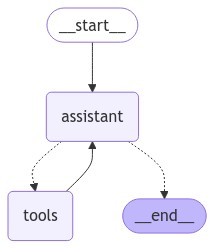

In [8]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## **Invoke the Graph (Perform a Task):**

In [14]:
messages = [HumanMessage(content="Add 3 and 4")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'req

Now, let's multiply by 2!

In [15]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'req

# **Agent With Memory**

## **State is Transient:**

In this context, "state is transient" refers to the fact that the graph state is only maintained within a single graph execution. Once the graph execution finishes, any state, including the results of previous steps, is lost.
For instance, if the user asks the model to "Add 3 and 4" and then later asks "Multiply that by 2," the model does not remember the result of "Add 3 and 4" (which is 7). This happens because the state, or memory of the previous action, is not automatically preserved between separate invocations.

This limitation affects the model's ability to handle multi-turn conversations where continuity and memory of past interactions are essential.

## **Persistence:**

Persistence is a solution to the transient nature of the state. It enables the graph to remember its previous states (or checkpoints) across multiple executions. Essentially, persistence allows the model to maintain "memory" between interactions by saving and restoring state.

**How is persistence implemented in LangGraph?**

LangGraph uses a checkpointer to store the graph’s state after each step. This enables the graph to resume from the last saved state when the next input is received.

## **MemorySaver:**

MemorySaver is an in-memory key-value store used to save and restore the state of the graph between different executions. In simpler terms, it's like a short-term memory for the graph. It doesn’t save data to a permanent storage system (like a database or file), but it can store state temporarily in memory for the duration of a session.

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

## **Thread ID:**

The thread_id is a unique identifier used to store the state of the conversation. Think of it like a conversation session ID that tracks the entire history of the interaction. Each time a new input is processed, it’s stored under a specific thread_id, allowing the graph to load the history and context of that session.

**Why is it important?**

The same thread_id across multiple executions allows the graph to pick up where it left off. For example, if the user first asks for "Add 3 and 4" and then later says "Multiply that by 2", the graph knows that "that" refers to the previously computed result of "7".

In [10]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'req



If we pass the same thread_id, then we can proceed from from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The HumanMessage we pass ("Multiply that by 2.") is appended to the above conversation.

So, the model now know that that refers to the The sum of 3 and 4 is 7..

In [11]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'req

Each step of the graph is saved in memory by the checkpointer. When the user inputs "Add 3 and 4", the result is stored as part of the state under thread_id = 1. When the user later says "Multiply that by 2", the system knows that that refers to the previously computed result of 7.

How does the graph know the context of "that"? Because the previous result (7) is saved under the thread_id in the MemorySaver, the graph can append the new input ("Multiply that by 2") to the previous conversation history, and thus correctly compute the result as 14.